In [1]:
#!/usr/bin/env python

import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 


from utils import dlc_practical_prologue as prologue
from utils.helpers import *
from utils.metrics import *
from utils.plot import plot_history

from models.proj1.weightSharing import WeightSharing

import torch
from torch import optim
from torch.autograd import Variable

import matplotlib

In [2]:
# load the data
train_input, train_target, train_classes, test_input, test_target, test_classes = \
    prologue.generate_pair_sets(nb=1000)

/home/mbanga/.pyenv/versions/deeplearning/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/mbanga/.pyenv/versions/deeplearning/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/mbanga/.pyenv/versions/deeplearning/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/mbanga/.pyenv/versions/deeplearning/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [3]:
def standard_wrapper(*data):
    return [Variable(t) for t in data]

In [4]:
def custom_wrapper(*data):
    return None

In [5]:
def wrap_data(*data, type_='standard'):
    switch = {
        'standard': standard_wrapper,
        'Net3': custom_wrapper
    }
    
    return switch.get(type_, None)(*data)    

In [6]:
def summary(model, optimizer, lr, training_time=None, NB_EPOCHS=None, MINI_BATCH_SIZE=None):
    print('model: {:>5}, criterion: {:>10}, optimizer: {:>10}, learning rate: {:6}, num epochs: {:3}, '
    'mini batch size: {:3}, training time: {:5.2f}, train error: {:5.2f}%, test error: {:5.2f}%'.format(
        model.__class__.__name__,
        model.criterion.__class__.__name__,
        opt.__class__.__name__,
        lr,
        NB_EPOCHS,
        MINI_BATCH_SIZE,
        training_time,
        compute_nb_errors(model, train_input, train_target, MINI_BATCH_SIZE) / train_input.size(0) * 100,
        compute_nb_errors(model, test_input, test_target, MINI_BATCH_SIZE) / test_input.size(0) * 100
        )
    )

In [7]:
optim = torch.optim.SGD(WeightSharing().parameters(), lr=0.001)

optim.param_groups[0]['lr']

0.001

In [10]:
# Compute mean and std for data
mean, std = train_input.mean(), train_input.std()

# Standardize data
train_input.sub_(mean).div_(std)
test_input.sub_(mean).div_(std)

# Wrap data in a Variable object
train_input, train_target, train_classes, test_input, test_target = \
    wrap_data(train_input, train_target, train_classes, test_input, test_target, type_='standard')


train_input_Net3 = train_input.view(-1, 1, 14, 14)
train_target_Net3 = train_classes.flatten()

# test different configurations
NB_EPOCHS = 100
MINI_BATCH_SIZE = 100
models = [WeightSharing]
opts = [torch.optim.SGD, torch.optim.Adam]
lrs = [1e-1, 1e-2, 1e-3]


for m in models:
    model = m()
    train_target, test_target = update_target_type(model, train_target, test_target)
    for opt in opts[:1]:
        for lr in lrs[:1]:      
            history = train_model(model, opt(model.parameters(), lr=lr), NB_EPOCHS, \
                    train_input, train_target, MINI_BATCH_SIZE)
            
            summary(model, opt, lr, training_time=history.training_time, NB_EPOCHS=NB_EPOCHS, MINI_BATCH_SIZE=MINI_BATCH_SIZE)                   

model: WeightSharing, criterion: BCEWithLogitsLoss, optimizer:       type, learning rate:    0.1, num epochs: 100, mini batch size: 100, training time: 12.82, train error:  3.30%, test error: 15.80%


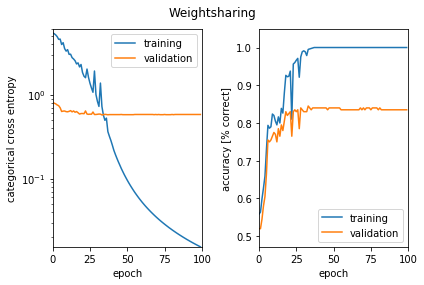

In [11]:
res = plot_history(history, 'Weightsharing', NB_EPOCHS)

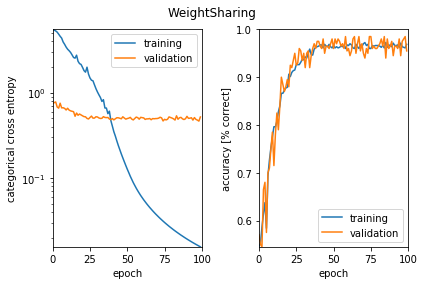

In [272]:
res = plot_history(mean_history([history], NB_EPOCHS), 'WeightSharing', NB_EPOCHS)

In [ ]:
xs = torch.arange(0, epochs).tolist()
# default transparency